In [24]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt 
from ase import Atoms
from ase.build import graphene
from ase.visualize import view
from ase.build import graphene_nanoribbon
from ase.neighborlist import neighbor_list
from ase.build import make_supercell

import abtem

# Structure


Cell([26.84, 17.21658502723464, 50.0])


(<Figure size 1000x500 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='x [Å]'>)

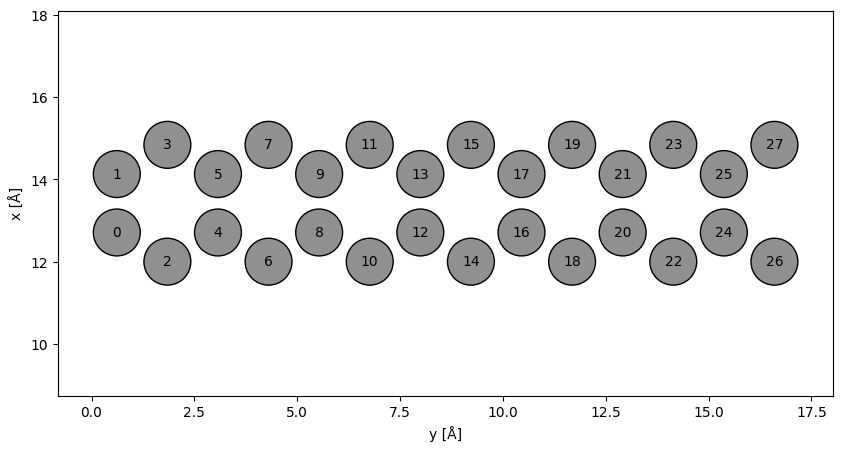

In [25]:
from functions import zgnr

Vpp_pi0=-2.7
Vpp_sigma0=-0.48

# N = 6 # width
# L = 1 # length
# num_cells = 24

N = 2 # width
L = 1 # length
num_cells = 7


unit_cell = zgnr(N,L)

unit_cell.rotate(90, (1, 0, 0), rotate_cell=False)

unit_cell.cell[1] = [0, unit_cell.cell[2,2],0]
unit_cell.cell[2] = [0,0,50.0]


# center in the cell
unit_cell.center()

# sort atoms by x, then y (correct order)
xyz = unit_cell.get_positions()
sorted_indices = np.lexsort((xyz[:, 0], xyz[:, 1]))  # no z sorting

unit_cell = unit_cell[sorted_indices]

# repeat
NR = unit_cell.repeat((1,num_cells,1))
# atoms = atoms.repeat((1,5,1))


print(NR.cell)
#view(NR)
abtem.show_atoms(NR,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))

In [70]:
unit_cell.cell

Cell([26.84, 2.4595121467478056, 50.0])

# Bandstructure

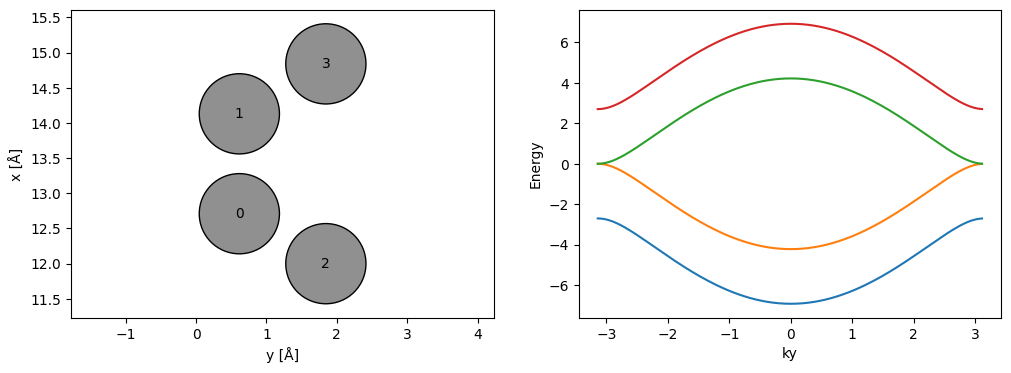

In [26]:
from functions import slater_koster
atoms2 = unit_cell.repeat([1,2,1])

H2,H_TB2,H_SK2,_,_= slater_koster(atoms2)
nhalf  = int(len(H2)/2)
h0 = H2[0:nhalf,0:nhalf] 
V = H2[0:nhalf,nhalf:]
kpts = np.pi*np.arange(-1,1,0.01)
eig = np.array([np.linalg.eigvalsh(h0 + np.exp(1j*k)*V + np.exp(-1j*k)*V.T) for k in kpts])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(unit_cell,plane='yx',numbering=True,merge = False,show_cell=False, ax=ax1)
ax2.plot(kpts,eig)
ax2.set_xlabel('ky')
ax2.set_ylabel('Energy')
plt.show()

# Top flake AA

(<Figure size 1000x500 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='z [Å]'>)

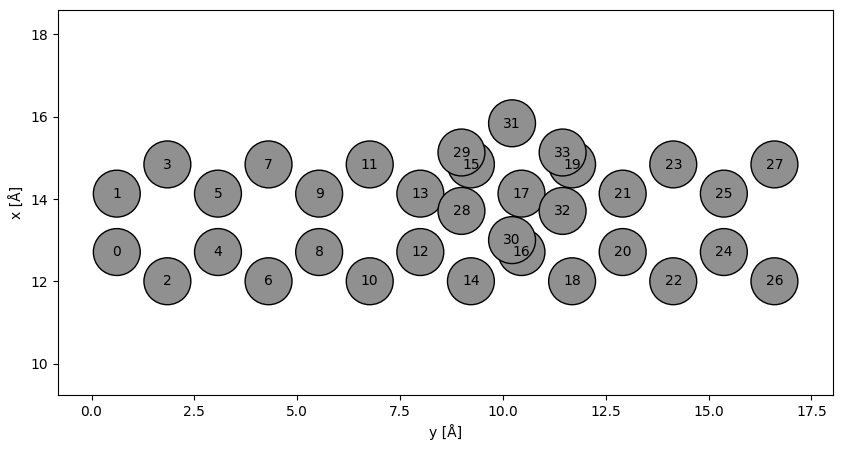

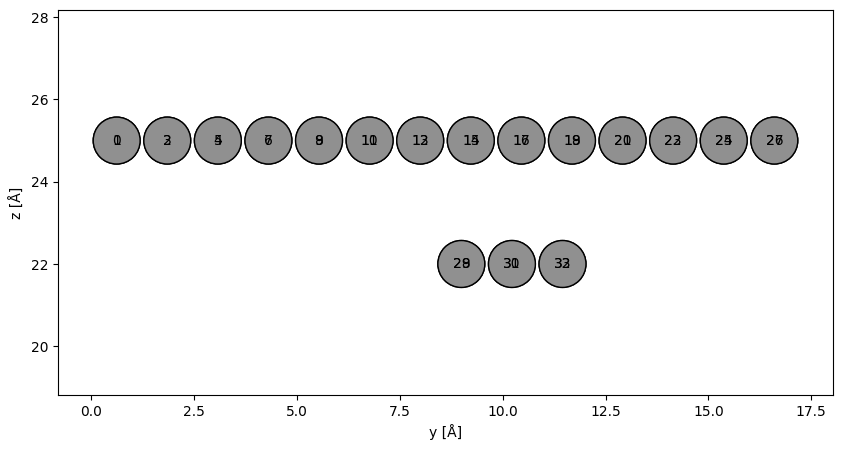

In [84]:
nL = 4

bottom = NR.copy()
top = NR.copy()

shiftx = 1
shifty = 1
shiftz = -3
shift = np.array([shiftx, shifty, shiftz])
top.positions += shift

num_del = nL*3

del top[0:num_del]
del top[len(top)-num_del+2::]
# change symbol to Nitrogen for identification
# top.symbols = 'N'
AAtop_C = bottom + top

abtem.show_atoms(AAtop_C,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))
abtem.show_atoms(AAtop_C,plane='yz',numbering=True,merge = False,show_cell=False,figsize=(10,5))



# Hamilton

In [85]:
def slater_koster_v2(
    atoms,
    cutoff=6,
    d0=1.42,
    d_gg=3.35,
    r0=0.45,
    Vpp_pi0=-2.7,
    Vpp_sigma0=-0.48,
    onsite=0.0,
    carbon_only=True
):
    """
    Compute Slater-Koster tight-binding Hamiltonian for graphene structures.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Atomic structure
    cutoff : float, optional
        Cutoff distance for interlayer hopping in Angstrom, default is 6
    d0 : float, optional
        In-plane C-C bond length in Angstrom, default is 1.42
    d_gg : float, optional
        Interlayer distance in Angstrom, default is 3.35
    r0 : float, optional
        Decay length in Angstrom, default is 0.45
    Vpp_pi0 : float, optional
        Pi-orbital hopping parameter in eV, default is -2.7
    Vpp_sigma0 : float, optional
        Sigma-orbital hopping parameter in eV, default is 0.48
    onsite : float, optional
        On-site energy in eV, default is 0.0
    carbon_only : bool, optional
        Whether to consider only carbon atoms, default is True
    
    Returns
    -------
    H : np.ndarray
        Total Hamiltonian matrix (H_TB + H_SK)
    H_TB : np.ndarray
        In-plane tight-binding Hamiltonian
    H_SK : np.ndarray
        Slater-Koster interlayer Hamiltonian
    H_pi : np.ndarray
        Pi-orbital contribution
    H_sigma : np.ndarray
        Sigma-orbital contribution
    """
    pos = atoms.positions
    N = len(atoms)

    H_TB = np.zeros((N, N))
    H_pi = np.zeros((N, N),)
    H_sigma = np.zeros((N, N))

    # onsite term (pi channel)
    for i in range(N):
        if not carbon_only and atoms[i].symbol == 'N':
            H_pi[i, i] = onsite #+ 1.5  # Nitrogen has higher onsite energy
        else:
            H_pi[i, i] = onsite

    # In plane hopping
    for i in range(N):
        ri = pos[i]
        z_i=pos[i][2]
        for j in range(i + 1, N):
            rj = pos[j]
            z_j=pos[j][2]
            dvec = rj - ri
            R = np.linalg.norm(dvec)
            # check if the two atoms lie on the same z plane
            if np.abs(z_i-z_j) < 0.1: 
                 # Make TB hamiltonian
                 dist = np.linalg.norm(ri -rj, axis=0)
                 if  R < 1.5 and R > 0.1:
                    hop = Vpp_pi0
                    # Scale hopping for N-C or N-N bonds when carbon_only=False
                    if not carbon_only and (atoms[i].symbol == 'N' or atoms[j].symbol == 'N'):
                        hop *= 0.7  # Weaker hopping for N-containing bonds
                    H_TB[i, j] = hop
                    H_TB[j, i] = hop
            else:
                # Make SK
                if R < cutoff and R > 1e-8:
    
                    # angle factors
                    cos_theta = dvec[2] / R
                    cos2 = cos_theta**2
                    sin2 = 1.0 - cos2
    
                    # distance dependent hoppings
                    Vpi = Vpp_pi0 * np.exp(-(R - d0) / r0)
                    Vsigma = Vpp_sigma0 * np.exp(-(R - d_gg) / r0)
    
                    # separated contributions
                    t_pi = Vpi * sin2
                    t_sigma = Vsigma * cos2
    
                    # fill matrices
                    H_pi[i, j] = t_pi
                    H_pi[j, i] = t_pi
    
                    H_sigma[i, j] = t_sigma
                    H_sigma[j, i] = t_sigma


    H_SK = H_pi + H_sigma
    H = H_TB + H_SK
    return H,H_TB,H_SK,H_pi,H_sigma

In [86]:
nF = len(top)
nL = 4
nR = 4

gglabel = 'shifted_top_C'
atoms = AAtop_C

# # pristine 
# atoms = bottom
# nL = 4
# nR = 4
# nF = 0
# gglabel = 'Pristine_V2'




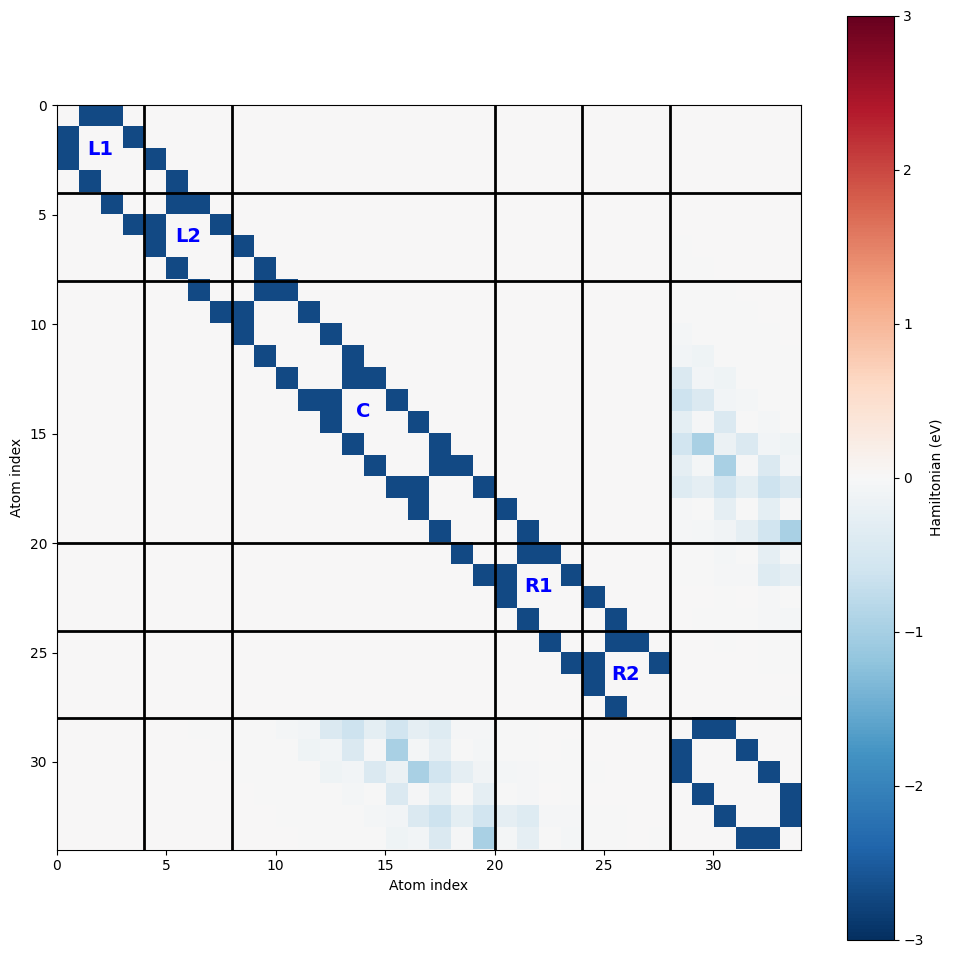

In [87]:
#from functions import slater_koster
H,H_TB,H_SK,_,_= slater_koster_v2(atoms,carbon_only=True)

Hbig = H
nC = len(NR) - 2*nL - 2*nR

# Boundaries
b0 = 0
b1 = nL
b2 = 2*nL
b3 = 2*nL + nC
b4 = 2*nL + nC + nR
b5 = 2*nL + nC + 2*nR #Hbig.shape[0]

plt.figure(figsize=(12,12))
# Use imshow with extent to align indices properly
n = Hbig.shape[0]
plt.imshow(Hbig, extent=(0, n, n, 0), cmap='RdBu_r', vmin=-3, vmax=3)
plt.colorbar(label='Hamiltonian (eV)')

# Draw block boundaries
for b in [b1, b2, b3, b4,b5]:
    plt.axhline(b, color='k', linewidth=2)
    plt.axvline(b, color='k', linewidth=2)

# Add text labels
plt.text((b0+b1)/2, (b0+b1)/2, "L1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b1+b2)/2, (b1+b2)/2, "L2", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b2+b3)/2, (b2+b3)/2, "C", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b3+b4)/2, (b3+b4)/2, "R1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b4+b5)/2, (b4+b5)/2, "R2", ha='center', va='center', color='b', fontsize=14, weight='bold')

plt.xlabel('Atom index')
plt.ylabel('Atom index')
plt.savefig('H_'+str(gglabel))
plt.show()


In [88]:
def SplitHamMoy_v2(H, nL, nR, nF):
    """
    Partition Hamiltonian H with block structure:
    L1 | L2 | C | R1 | R2
            |top|
    Device D = L2 | C | R1|top
    """

    no = H.shape[0]
    nC = no - 2*nL - 2*nR - nF

    if nC < 1:
        print("Setup error: central region size =", nC)
        print("Use [L | L | C | R | R] setup")
        return

    # Boundaries
    b0 = 0
    b1 = nL
    b2 = 2*nL
    b3 = 2*nL + nC
    b4 = 2*nL + nC + nR
    b5 = 2*nL + nC + 2*nR
    b6 = no

    # Left lead onsite (L1)
    HL = H[b0:b1, b0:b1]

    # L2 → L1 hopping
    VL = H[b1:b2, b0:b1]

    # Coupling L2 ↔ C
    VCL = H[b2:b3, b1:b2]   # C → L2
    VLC = VCL.T.conj()      # L2 → C

    # Central region
    HC = H[b2:b3, b2:b3]

    # Coupling C ↔ R1
    VCR = H[b2:b3, b3:b4]   # C → R1
    VRC = VCR.T.conj()      # R1 → C

    # R1 → R2 hopping
    VR = H[b3:b4, b4:b5]

    # Right lead onsite (R2)
    HR = H[b4:b5, b4:b5]

    # Device block
    rows = np.r_[b1:b4, b5:b6]
    cols = np.r_[b1:b4, b5:b6]

    HD = H[np.ix_(rows, cols)]

    HF = H[b5:b6, b5:b6]

    # Lead–device couplings
    VLD = H[b1:b4, b0:b1]   # L1 → device
    VRD = H[b1:b4, b4:b5]   # device → R2
    
    # Device block
    rows = np.r_[b1:b4, b5:b6]
    cols = np.r_[b1:b4, b5:b6]
    HD = H[np.ix_(rows, cols)]  # [web:51]
    # Return in left → right order
    return HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD, HF,rows

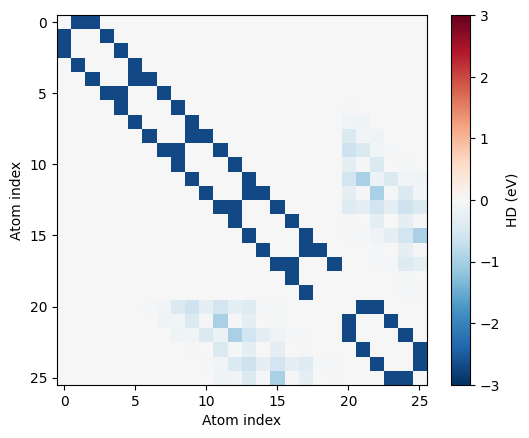

In [89]:
#from functions import SplitHamMoy
HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD, HF, rows =SplitHamMoy_v2(H, nL, nR, nF = nF)
plt.imshow(HD,  cmap='RdBu_r', vmin=-3, vmax=3)
plt.xlabel('Atom index')
plt.ylabel('Atom index')
plt.colorbar(label='HD (eV)')

plt.savefig('HD_'+str(gglabel))
plt.show()

# DOS

# Transmission

In [90]:
from functions import get_surface_greens_function
def compute_transmission_caroli_v3(energy, eta,HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD,method=1 ):
    """
    Computes transmission T(E) based on the formulas:
    Sigma_L = V_LD.dag @ g_L @ V_LD
    Sigma_R = V_RD @ g_R @ V_RD.dag
    T(E) = Trace[Gamma_R @ G_D @ Gamma_L @ G_D_dag]
    """
    z = energy + 1j * eta

    # 1. Surface Green's Functions for leads
    gl_s,gl_b,sigmal_s,sigmal_b = get_surface_greens_function(HL, VL,z)
    gr_s,gr_b,sigmar_s,sigmar_b = get_surface_greens_function(HR, VR,z)

    if method == 2:

        # Infer sizes from blocks
        nL = HL.shape[0]
        nR = HR.shape[0]
        nC = HC.shape[0]
        dim = nL+nC+nR # of bottom device part
        

        nD = HD.shape[0]
        I = np.eye(nD, dtype=complex)

        h_eff = HD.astype(complex).copy()
        
        sigma_L = sigmal_s
        sigma_R = sigmar_s


        h_eff[0:nL, 0:nL] += sigma_L

        h_eff[nL + nC:dim, nL + nC:dim] += sigma_R #

        g = np.linalg.inv(z * I - h_eff)

        gamma_L = np.zeros((nD, nD), dtype=complex)
        gamma_R = np.zeros((nD, nD), dtype=complex)

        gamma_L[0:nL, 0:nL] = 1j * (sigma_L - sigma_L.T.conj())
        gamma_R[nL + nC:dim, nL + nC:dim] = 1j * (sigma_R - sigma_R.T.conj())

        g_C = g
        t_matrix = gamma_R @ g_C @ gamma_L @ g.T.conj()

        
    # 5. Transmission T(E) = Trace[Gamma_R @ G_D @ Gamma_L @ G_D_dag]
        transmission= np.trace(t_matrix).real

    # 6. Current Jnm = 1/hbar*Im[Hnm*Anm] 
        ham = HD.astype(complex).copy()
        AL = g_C @ gamma_L @ g.T.conj()
        
        hbar = 1#6.582119569e-16  # eV*s
        tol = 1e-6
        mask = ~np.isclose(ham, 0.0, atol=tol, rtol=0.0) #np.abs(ham) > tol # mask to only pick neigbors
        
        J = np.zeros_like(ham, dtype=float)
        J[mask] = (1/hbar) * np.imag(ham[mask] * AL[mask])
    
    return transmission, gl_s, gl_b, gr_s, gr_b, g_C,sigma_L,sigma_R,J,ham,g_C

In [91]:
#from functions import compute_transmission_caroli
# Calculate spectrum
energies = np.linspace(-10.0, 10.0, 1000)
results_2 = [compute_transmission_caroli_v3(E, 1e-5,HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD,method=2) for E in energies]

# Unpack each column of the results
transmission_2, gl_s_2, gl_b_2, gr_s_2, gr_b_2, g_d_2,sigma_l_2,sigma_r_2,J,ham,G= map(np.array, zip(*results_2))

# DOS

In [92]:
dos = np.array([-np.imag(np.trace(greens_device)) / np.pi for greens_device in G])

# Save data

In [93]:
# save energies and transmission as csv 
data = np.column_stack((energies, transmission_2,dos))
np.savetxt("results_"+gglabel+".csv", data, delimiter=",", header="Energy,Transmission,DOS", comments='')

# Pristine

In [94]:
# unpack pristine transmission from csv
data_pristine = np.loadtxt("results_pristine.csv", delimiter=",", skiprows=1)
energies_pristine = data_pristine[:, 0]
transmission_pristine = data_pristine[:, 1]
dos_pristine = data_pristine[:, 2]

# AA_top

In [103]:
data_AAtop_C = np.loadtxt("results_AAtop_C.csv", delimiter=",", skiprows=1)
energies_AAtop_C = data_AAtop_C[:, 0]
transmission_AAtop_C = data_AAtop_C[:, 1]
dos_AAtop_C = data_AAtop_C[:, 2]

# Plot data

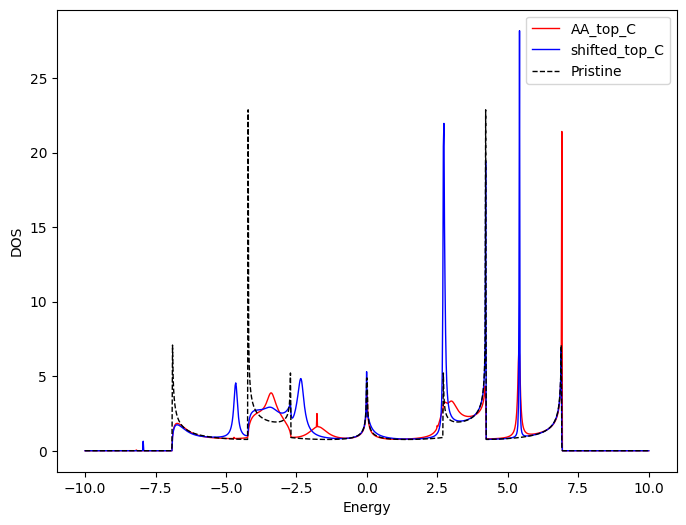

In [106]:
# plot DOS
plt.figure(figsize=(8, 6))
# AA_top
plt.plot(energies_AAtop_C, dos_AAtop_C,'r',lw = 1, label='AA_top_C')

#current
plt.plot(energies, dos,'b',lw = 1, label=gglabel)
# plt.scatter(energies[energy_idx],dos[energy_idx],color = 'b')

#pristine
plt.plot(energies_pristine, dos_pristine,'k--',lw = 1, label='Pristine')

plt.xlabel('Energy')
plt.ylabel('DOS')
plt.legend()
plt.savefig('DOS_'+str(gglabel))
plt.show()

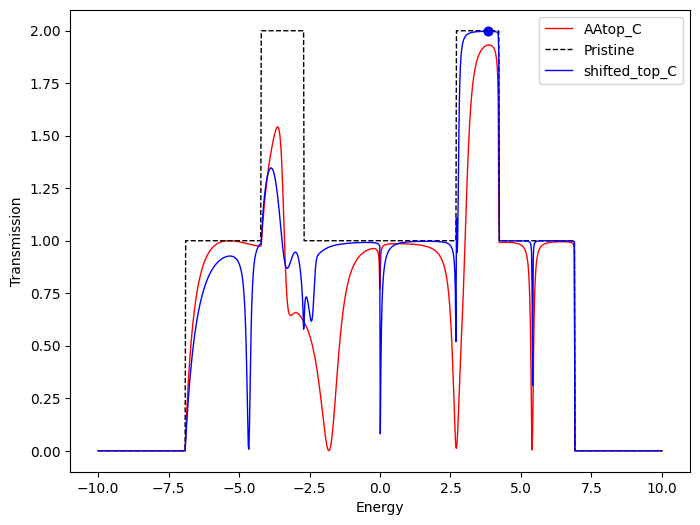

In [107]:
energy_idx = 690

# --- Plotting ---
plt.figure(figsize=(8, 6))

# AAtop
plt.plot(energies_AAtop_C,transmission_AAtop_C,color = 'r',lw = 1,label = 'AAtop_C')

# pristine
plt.plot(energies_pristine, transmission_pristine, '--k', lw=1,label='Pristine')
plt.scatter(energies_pristine[energy_idx],transmission_pristine[energy_idx],color = 'b')
# current
plt.plot(energies, transmission_2, '-b', lw=1,label=gglabel)
plt.scatter(energies[energy_idx],transmission_2[energy_idx],color = 'b')
plt.xlabel("Energy")
plt.ylabel("Transmission")
plt.legend()
plt.savefig('Transmission_'+str(gglabel))
plt.show()

In [97]:
print(energies[energy_idx])

3.8138138138138142


In [98]:
bottom_idxs = range(nL,2*nL+nC+nR)
top_idxs = range(2*nL+nC+2*nR,len(H))

device_idxs = list(bottom_idxs) + list(top_idxs)


In [99]:
from matplotlib.patches import FancyArrowPatch

J_dev = J[energy_idx]          # must be same shape as HD (Ndev, Ndev)

# pick upper-triangle nonzeros in device indexing
iu, ju = np.triu_indices_from(J_dev, k=1)
sel = np.abs(J_dev[iu, ju]) > 1e-12

# device pairs
i_dev = iu[sel]
j_dev = ju[sel]

# map to full/ASE indices
I_full = rows[i_dev]
J_full = rows[j_dev]

In [100]:
# fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(16, 6))
# abtem.show_atoms(top,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8),ax = ax1)

# for i,idx in enumerate(top_idxs): 
#     ax1.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-1000*np.imag(np.diag(g_d_2[energy_idx]))[i],c='r')

# plt.figure(figsize=(20, 8))
# abtem.show_atoms(atoms,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8),ax =ax2)

# for i,idx in enumerate(bottom_idxs): 
#     ax2.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-1000*np.imag(np.diag(g_d_2[energy_idx]))[i],c='r')

# # arrow
# pairs = [(6, 8), (8, 9)]

# for idv, jdv, If, Jf in zip(i_dev, j_dev, I_full, J_full):
#     Jnm = J_dev[idv, jdv]   # value in device indexing (correct matrix element) 

#     # coordinates consistent with plane='yx'
#     x_n, y_n, z_n = atoms.positions[If, 1], atoms.positions[If, 0], atoms.positions[If,2]
#     x_m, y_m, z_m = atoms.positions[Jf, 1], atoms.positions[Jf, 0], atoms.positions[Jf,2]
    
#     # thickness ~ strength (tune these two numbers)
#     lw = Jnm*10 #0.5 + 10.0 * np.abs(Jnm)

#     # optional: color by sign
#     col = 'tab:red' if Jnm >= 0 else 'tab:blue'

#     arrowyx = FancyArrowPatch(
#         (x_n, y_n), (x_m, y_m),
#         arrowstyle='-|>',          # simple directed arrow [web:31]
#         mutation_scale=20,         # head size (tune)
#         linewidth=lw,              # thickness encodes |Jnm| [web:31]
#         color=col
#     )
#     arrowyz = FancyArrowPatch(
#         (z_n, y_n), (z_m, y_m),
#         arrowstyle='-|>',          # simple directed arrow [web:31]
#         mutation_scale=20,         # head size (tune)
#         linewidth=lw,              # thickness encodes |Jnm| [web:31]
#         color=col
#     )
    
#     ax2.add_patch(arrowyx)


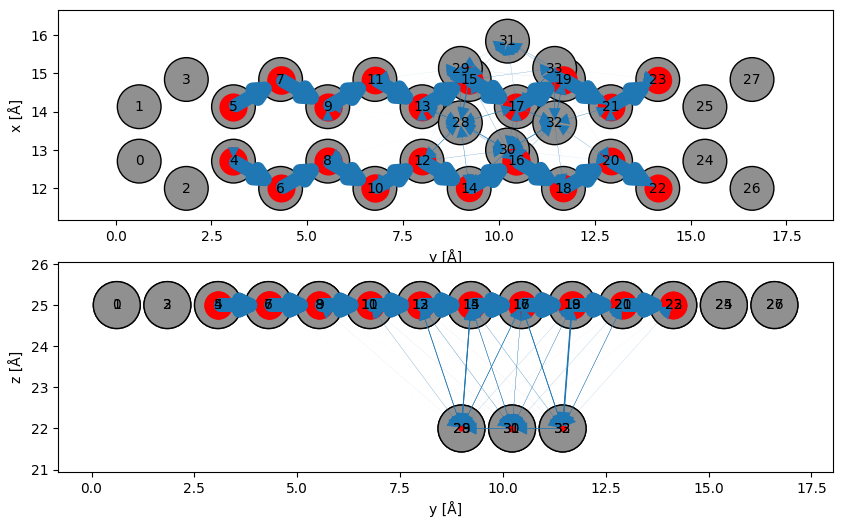

In [101]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# YX plane (top view)
abtem.show_atoms(atoms, plane='yx', numbering=True, merge=False, show_cell=False, ax=ax1)
# ax1.set_title('YX Plane (Top View)', fontsize=12)

for i, idx in enumerate(bottom_idxs): 
    ax1.scatter(atoms.positions[idx, 1], atoms.positions[idx, 0], 
               s=-1000*np.imag(np.diag(g_d_2[energy_idx]))[i], c='r')

# YZ plane (side view 1)
abtem.show_atoms(atoms, plane='yz', numbering=True, merge=False, show_cell=False, ax=ax2)
# ax2.set_title('YZ Plane (Side View 1)', fontsize=12)

for i, idx in enumerate(device_idxs): 
    ax2.scatter(atoms.positions[idx, 1], atoms.positions[idx, 2], 
               s=-1000*np.imag(np.diag(g_d_2[energy_idx]))[i], c='r')

# # ZX plane (side view 2)
# abtem.show_atoms(atoms, plane='zx', numbering=True, merge=False, show_cell=False, ax=ax3)
# ax3.set_title('ZX Plane (Side View 2)', fontsize=12)

# for i, idx in enumerate(bottom_idxs): 
#     ax3.scatter(atoms.positions[idx, 2], atoms.positions[idx, 0], 
#                s=-1000*np.imag(np.diag(g_d_2[energy_idx]))[i], c='r')

# Add arrows to all three planes
for idv, jdv, If, Jf in zip(i_dev, j_dev, I_full, J_full):
    Jnm = J_dev[idv, jdv]
    
    x_n, y_n, z_n = atoms.positions[If, 0], atoms.positions[If, 1], atoms.positions[If, 2]
    x_m, y_m, z_m = atoms.positions[Jf, 0], atoms.positions[Jf, 1], atoms.positions[Jf, 2]
    
    lw = np.abs(Jnm) * 20
    col = 'tab:blue'
    
    # Reverse arrow direction if Jnm is negative
    if Jnm >= 0:
        start_yx, end_yx = (y_n, x_n), (y_m, x_m)
        start_yz, end_yz = (y_n, z_n), (y_m, z_m)
    else:
        start_yx, end_yx = (y_m, x_m), (y_n, x_n)
        start_yz, end_yz = (y_m, z_m), (y_n, z_n)
    
    # YX plane arrow
    arrow_yx = FancyArrowPatch(
        start_yx, end_yx,
        arrowstyle='-|>',
        mutation_scale=20,
        linewidth=lw,
        color=col
    )
    ax1.add_patch(arrow_yx)
    
    # YZ plane arrow
    arrow_yz = FancyArrowPatch(
        start_yz, end_yz,
        arrowstyle='-|>',
        mutation_scale=20,
        linewidth=lw,
        color=col
    )
    ax2.add_patch(arrow_yz)
    
    # # ZX plane arrow
    # arrow_zx = FancyArrowPatch(
    #     (z_n, x_n), (z_m, x_m),
    #     arrowstyle='-|>',
    #     mutation_scale=20,

    #     linewidth=lw,

    #     color=colplt.show()

    # )plt.tight_layout()

    # ax3.add_patch(arrow_zx)

# Animation

In [61]:
import imageio.v2 as imageio
import tempfile
import os

# Create frames for gif
frames = []
energy_indices = range(100, 900, 10)  # sample every 100th index

for idx in energy_indices:
    # Layout: top row transmission; bottom rows for YX and YZ planes with arrows
    fig = plt.figure(figsize=(16, 14))
    gs = fig.add_gridspec(3, 1, height_ratios=[1, 1.5, 1.5])
    ax_trans = fig.add_subplot(gs[0, :])
    ax_yx = fig.add_subplot(gs[1, :])
    ax_yz = fig.add_subplot(gs[2, :])
    
    # Top panel: Transmission with current energy marked
    ax_trans.plot(energies/(-2.7), transmission_2, 'k', lw=2)
    ax_trans.plot(energies_pristine/(-2.7), transmission_pristine, 'r--', lw=2,label ='Pristine')
    ax_trans.scatter(energies[idx]/(-2.7), transmission_2[idx], color='r', s=100, zorder=5)
    ax_trans.axvline(energies[idx]/(-2.7), color='r', ls='--', alpha=0.3)
    ax_trans.set_xlabel("Energy (eV/Vpppi)", fontsize=12)
    ax_trans.set_ylabel("T(E)", fontsize=12)
    ax_trans.set_title(f"Energy index: {idx}, E = {energies[idx]/(-2.7):.3f} eV/Vpppi", fontsize=14)
    ax_trans.grid(alpha=0.3)
    
    # YX plane with LDOS and arrows
    abtem.show_atoms(atoms, plane='yx', numbering=True, merge=False, 
                     show_cell=False, ax=ax_yx)
    ax_yx.set_title("YX Plane (Top View)", fontsize=13)
    ax_yx.set_xlabel("y position (Å)", fontsize=12)
    ax_yx.set_ylabel("x position (Å)", fontsize=12)
    
    # Add LDOS markers to YX plane
    for i, atom_idx in enumerate(bottom_idxs):
        ldos_val = -np.imag(np.diag(g_d_2[idx]))[i]
        if ldos_val > 0:
            ax_yx.scatter(atoms.positions[atom_idx, 1], atoms.positions[atom_idx, 0],
                             s=1000*ldos_val, c='red', alpha=0.7,
                             edgecolors='darkred', linewidths=0.8, zorder=10)
    
    # YZ plane with LDOS and arrows
    abtem.show_atoms(atoms, plane='yz', numbering=True, merge=False, 
                     show_cell=False, ax=ax_yz)
    ax_yz.set_title("YZ Plane (Side View)", fontsize=13)
    ax_yz.set_xlabel("y position (Å)", fontsize=12)
    ax_yz.set_ylabel("z position (Å)", fontsize=12)
    
    # Add LDOS markers to YZ plane
    for i, atom_idx in enumerate(device_idxs):
        ldos_val = -np.imag(np.diag(g_d_2[idx]))[i]
        if ldos_val > 0:
            ax_yz.scatter(atoms.positions[atom_idx, 1], atoms.positions[atom_idx, 2],
                             s=1000*ldos_val, c='red', alpha=0.7,
                             edgecolors='darkred', linewidths=0.8, zorder=10)
    
    # Add arrows to both planes
    J_dev = J[idx]
    iu, ju = np.triu_indices_from(J_dev, k=1)
    sel = np.abs(J_dev[iu, ju]) > 1e-12
    
    i_dev = iu[sel]
    j_dev = ju[sel]
    
    I_full = rows[i_dev]
    J_full = rows[j_dev]
    
    for idv, jdv, If, Jf in zip(i_dev, j_dev, I_full, J_full):
        Jnm = J_dev[idv, jdv]
        
        x_n, y_n, z_n = atoms.positions[If, 0], atoms.positions[If, 1], atoms.positions[If, 2]
        x_m, y_m, z_m = atoms.positions[Jf, 0], atoms.positions[Jf, 1], atoms.positions[Jf, 2]
        
        lw = np.abs(Jnm) * 10
        col = 'tab:blue'
        
        # Reverse arrow direction if Jnm is negative
        if Jnm >= 0:
            start_yx, end_yx = (y_n, x_n), (y_m, x_m)
            start_yz, end_yz = (y_n, z_n), (y_m, z_m)
        else:
            start_yx, end_yx = (y_m, x_m), (y_n, x_n)
            start_yz, end_yz = (y_m, z_m), (y_n, z_n)
        
        # YX plane arrow
        arrow_yx = FancyArrowPatch(
            start_yx, end_yx,
            arrowstyle='-|>',
            mutation_scale=20,
            linewidth=lw,
            color=col
        )
        ax_yx.add_patch(arrow_yx)
        
        # YZ plane arrow
        arrow_yz = FancyArrowPatch(
            start_yz, end_yz,
            arrowstyle='-|>',
            mutation_scale=20,
            linewidth=lw,
            color=col
        )
        ax_yz.add_patch(arrow_yz)
    
    plt.tight_layout()
    
    # Save to temporary file and read back
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
        fig.savefig(tmp.name, dpi=110, bbox_inches='tight')
        tmp_path = tmp.name
    frames.append(imageio.imread(tmp_path))
    os.unlink(tmp_path)
    plt.close(fig)
    
    if idx % 100 == 0:
        print(f"Processing frame {idx}...")

# Save as MP4
imageio.mimsave('ldos_animation_'+str(gglabel)+'.mp4', frames, fps=10)
print("Animation saved as ldos_animation_"+str(gglabel)+".mp4")

Processing frame 100...
Processing frame 200...
Processing frame 300...
Processing frame 400...
Processing frame 500...
Processing frame 600...
Processing frame 700...
Processing frame 800...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1756, 1525) to (1760, 1536) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Animation saved as ldos_animation_AAtop_C.mp4
